In [1]:
import numpy as np
import vector
import scipy 
from scipy.integrate import quad 
import matplotlib.pyplot as plt

import sys

In [2]:
sys.path.append('support')
import EM_Basics as EM_basics
import Waveform_Basics as Waveform_basics


**Note from Vector library and coordinates:**

For 3D vectors (e.g. $(E_x, E_y, E_z)$), the angles in [spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system) are defined as follows:

- $\varphi$ (aka azimuthal), angle between the projection of *vector* on the $xy$ plane and the $x$ axis: **phi**
- $\theta$ (aka polar), angle between *vector* and $z$ axis: **theta**
- $r$ (aka *radial distance*), distance to origin ($\rho$ = $r$*$sin(\theta)$): implemented via **rho**

In [ ]:
# Useful constants:

mu0 = 4*np.pi*1e-7   # H/m          Permeability of free space
eps0 = 8.854*1e-12   # F/m          Permitivity of free space



In [ ]:
# Derived constants:

c = 1/np.sqrt(mu0*eps0)          # m/s      Velocity of propagation in free space
eta0 = np.sqrt(mu0/eps0)         # Ohm      Intrinsic impedance of free space


In [4]:
array = Waveform_basics.waveForm.from_time_csv("data/Hong15m.csv", 1e-9, 1e3)

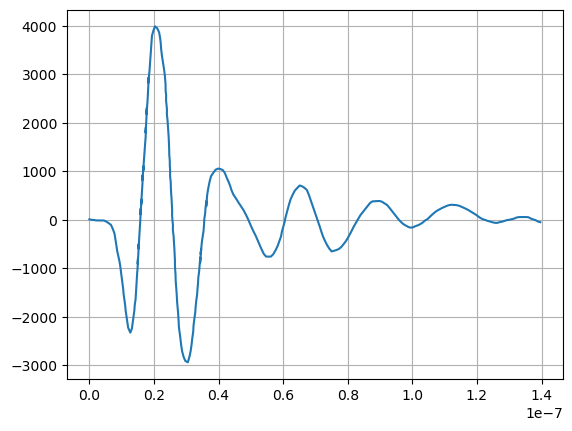

In [8]:
# Source: WORKING

#array = np.genfromtxt("data/waveformR.csv", delimiter=",")
#array = np.genfromtxt("data/Hong15m.csv", delimiter=",")

time_s = (array.time[:]-array.time[0])  # Check units of your source plot
E_volt = array.amplitude  # Check units of your source plot

# TL parameters:
#R = 1       # [Ohm/m]
#L = 1e-6    # [H/m]
#C = 1e-12   # [F/m]
#G = 1       # [1/Ohm / m]

plt.plot(time_s,E_volt)
plt.grid(True)

In [9]:
time_s_interp, E_volt_interp = array.interpolateSignal(1024)

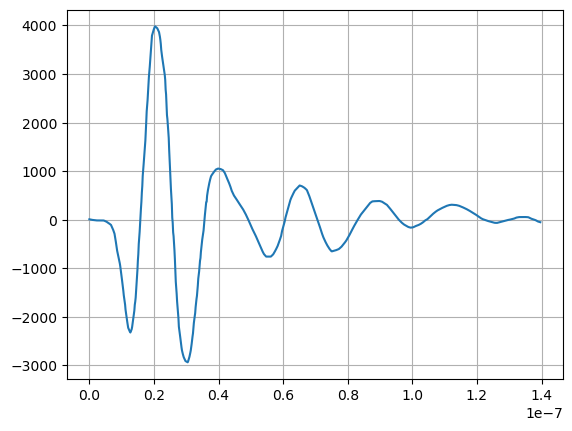

In [10]:
# We resample the waveform to a regular grid (in time).

#time_s_interp = np.linspace(0, (time_s[-1]-time_s[0]), 1024)
#E_volt_interp = np.interp(time_s_interp, time_s, E_volt)


plt.plot(time_s_interp , E_volt_interp)
plt.grid(True)

In [ ]:
def uerf(t,ta,tb,td,tf):
    """ Quasi-rectangular unitary pulse function.
    ta-tb = FWHM
    td = 10 to 90 % rise-time
    tf = 90 to 10 % fall-time"""
    arg1 = (t-tb)/(0.55*td)
    arg2 = (t-ta)/(0.55*tf)
    result = 0.5*(scipy.special.erf(arg1) - scipy.special.erf(arg2)) 
    return result

In [ ]:
t = np.linspace(0,100,100)
plt.plot(t,uerf(t,90,10,5,5))

In [ ]:
# Windowing digitized signal:
#ta-tb = FWHM
#td = 10 to 90 % rise-time
#tf = 90 to 10 % fall-time"""
ta = 135e-9
tb = 5e-9
td = 2e-9
tf = 2e-9
E_volt_interp_w = E_volt_interp*uerf(time_s_interp,ta,tb,td,tf)
plt.plot(time_s_interp , E_volt_interp_w)
plt.grid(True)

In [ ]:
# Padding with zeroes in time
ntotpad = 4096
E_volt_interp_w_pad = np.pad(E_volt_interp_w, 
                             (0, ntotpad - len(E_volt_interp_w)%ntotpad), 
                             'constant')
delta_t = time_s_interp[1]-time_s_interp[0] 
time_interp_w_pad = np.arange(ntotpad)*delta_t
plt.plot(time_interp_w_pad, E_volt_interp_w_pad)
plt.grid(True)

In [ ]:
1/(delta_t*ntotpad)

In [ ]:

fft_E = np.fft.fft(E_volt_interp_w_pad)
freq = np.fft.fftfreq(ntotpad, d=delta_t)
idx = np.argsort(freq)
plt.xscale("log")
plt.yscale("log")
#plt.xlim(-1e8, 1e8)
plt.xlim(1e5, 3e9)
plt.plot(freq[0:int(ntotpad/2)], np.abs(fft_E[0:int(ntotpad/2)]))
#plt.plot(freq[idx], np.abs(fft_E[idx]))

In [ ]:
#print(freq[0:5])
print(fft_E[int(ntotpad/2)-2:int(ntotpad/2)+2])
print(freq[int(ntotpad/2)-2:int(ntotpad/2)+2])


In [ ]:
fft_all = Waveform_basics.spectrumRealSignal(ntotpad, fft_E)
print(len(fft_E))
print(len(fft_all))
#plt.xscale("log")
plt.yscale("log")
plt.plot(freq[idx], np.abs(fft_all[idx]))

#fft_E_pad = np.pad(fft_E[0:int(ntotpad/2)], 
#                   (0, ntotpad - len(fft_E[0:int(ntotpad/2)])%ntotpad),
#                   'constant')
inv_fft_pad = np.fft.ifft(fft_all)




In [ ]:
1/(2*delta_t)/(1e9)

In [ ]:
#plt.plot(time_interp_w_pad, np.real(inv_fft_pad), time_interp_w_pad, E_volt_interp_w_pad)
plt.plot(time_interp_w_pad, (np.real(inv_fft_pad) - E_volt_interp_w_pad))

**Impingin plane wave**:
The impinging plane wave is defined as follows:
![](images/impingingPlaneWaveDef.JPG) 

In [ ]:
# Impinging plane wave:

E0Inc = 1        # RMS value of the field intensity, V/m
#f = 1e6         # Hz

#Incidence:
# Note for user:
# If thetaIn = 0 or 180, the polarization of E is associated simply to the azimuthal angle phiIn (alphaIn is not used, cause is undefined)
thetaIn = 90      # Degrees, 
phiIn = 45        # Degrees
alphaIn = -90      # Degrees


# Impinging field derived quantities

thetaInRad = thetaIn*np.pi/180     # 0 < thetaIn< 180
phiInRad = phiIn*np.pi/180
alphaInRad = alphaIn*np.pi/180

In [ ]:
# Quick check on impinging field

f = 10e3
omega_ = 2*np.pi*f    # rad/s
lambda_ = c/f         # m
wavenumber = omega_*np.sqrt(mu0*eps0)
waveVector = vector.obj(phi = phiInRad, theta = thetaInRad, rho = -1*wavenumber*np.sin(thetaInRad)) # Ingoing wave (therefore directed towards -1.0*rho)

EIncVector = EM_basics.linPolEField(E0Inc, thetaInRad, phiInRad, alphaInRad)  # Assemble EIncVector from linearly polarized planewave definition

incPw = EM_basics.planeWave(EIncVector, waveVector)

In [ ]:
incPw.waveVector.y

In [ ]:
# Pandas-like arguments (dict from names to column arrays)
obs = vector.array({"x": [0.0, 0.0], "y": [0.0, 0.0] , "z": [0.0, 1]})
#obs = vector.obj(x = 0, y = 0, z = 1)    
incPw.obsEField(obs)

In [ ]:
# TL equation:
def Dterm(Z0, Z1, Z2, gamma_, s):
    result = ( (Z0*(Z1+Z2)*np.cosh(gamma_*s)) + ((Z0**2+Z1*Z2)*np.sinh(gamma_*s)) )
    if(np.isclose(result, 0.0, atol=1e-10)):
        print("Warning: Dterm is too close to zero; replacing Dterm with 1e-10")
        result = 1e-10
    
    return result

def IntZ_Load_0(z, incPw, b, y, Z0, Z2, gamma_, s):
    obsx_b = vector.obj(x = b, y = y, z = z)
    obsx_0 = vector.obj(x = 0, y = y, z = z)
    K_z_omega = incPw.obsEField(obsx_b).z - incPw.obsEField(obsx_0).z
    
    return K_z_omega*( Z0*np.cosh(gamma_*(s-z)) + Z2*np.sinh(gamma_*(s-z)) )
    
def IntZ_Load_S(z, incPw, b, y, Z0, Z1, gamma_):
    obsx_b = vector.obj(x = b, y = y, z = z)
    obsx_0 = vector.obj(x = 0, y = y, z = z)
    K_z_omega = incPw.obsEField(obsx_b).z - incPw.obsEField(obsx_0).z
    
    return K_z_omega*( Z0*np.cosh(gamma_*(z)) + Z1*np.sinh(gamma_*(z)) )    

def IntEx_Load(x, incPw, y, z):
    obsz_0 = vector.obj(x = x, y = y, z = z)
    return incPw.obsEField(obsz_0).x


def c_quad(func, a, b, args): # Integrating 1D complex functions (int(complex) = int(real)+j*int(imag)) 
# Modified from: https://stackoverflow.com/questions/5965583/use-scipy-integrate-quad-to-integrate-complex-numbers
    def real_func(*someargs):
        return np.real(func(*someargs))
    def imag_func(*someargs):
        return np.imag(func(*someargs))
    real_integral = quad(real_func, a, b, args)
    imag_integral = quad(imag_func, a, b, args)
    return (real_integral[0] + 1j*imag_integral[0])#, real_integral[1:], imag_integral[1:])

In [ ]:
# TL (two wire) dimensions:
b = 1  # Separation between conductors, [m]
s = 60     # Lenght of the TL             , [m]
a = 1e-2

# TL derived quantities:

#Z = R + 1j*omega_*L
#Y = G + 1j*omega_*C

#alpha = 0
#beta = omega_/c
#gamma_ = alpha+1.0j*beta  #np.sqrt(Z*Y)
Z0 = 120*np.log(2*b/a)    # np.sqrt(Z/Y)
print(Z0)

In [ ]:
Z1 = 0     # load on z = 0, [Ohm]
Z2 = 635     # load on z = s, [Ohm]

In [ ]:
#fstart = 10e3
#fstop = 100e6
#nfreq = 100 

#f = freq[0:int(ntotpad/2)], np.abs(fft_E[0:int(ntotpad/2)])

EIncVector = EM_basics.linPolEField(E0Inc, thetaInRad, phiInRad, alphaInRad)  # Assemble EIncVector from linearly polarized planewave definition

TF_S = []
TF_0 = []
IS_list = []
I0_list = []
for f, waveform in zip(freq[0:int(ntotpad/2)+1], fft_E[0:int(ntotpad/2)+1]):#np.geomspace(fstart, fstop, num=nfreq, endpoint=True):

    #print(f)
    #print(waveform)
    if(np.isclose(f, 0.0, atol=1e-12)):
        IS = 0.0
        I0 = 0.0
    else:
        omega_ = 2*np.pi*f    # rad/s
        #lambda_ = c/f         # m
        wavenumber = omega_*np.sqrt(mu0*eps0)
        waveVector = vector.obj(phi = phiInRad, theta = thetaInRad, rho = -1*wavenumber*np.sin(thetaInRad)) # Ingoing wave (therefore directed towards -1.0*rho)

        incPw = EM_basics.planeWave(EIncVector, waveVector)    # Plane wave definition

        # TL parameters
        alpha = 0.0
        beta = omega_/c
        gamma_ = alpha+1.0j*beta  #np.sqrt(Z*Y)

        I0 = (1/Dterm(Z0, Z1, Z2, gamma_, s))*(c_quad(IntZ_Load_0, 0, s, args=(incPw, b, 0, Z0, Z2, gamma_, s)) + 
                                       (Z0*np.cosh(gamma_*s) + Z2*np.sinh(gamma_*s))*c_quad(IntEx_Load, 0, b, 
                                                                                      args=(incPw, 0, 0)) -
                                      Z0*c_quad(IntEx_Load, 0, b, args=(incPw, 0, s)))
    
        IS = (1/Dterm(Z0, Z1, Z2, gamma_, s))*(c_quad(IntZ_Load_S, 0, s, args=(incPw, b, 0, Z0, Z1, gamma_)) + 
                                       (Z0)*c_quad(IntEx_Load, 0, b, args=(incPw, 0, 0)) -
                                       (Z0*np.cosh(gamma_*s) + Z1*np.sinh(gamma_*s))*c_quad(IntEx_Load, 0, b, 
                                                                                         args=(incPw, 0, s)))
    #TF.append(20*np.log10(np.abs(IS)))
    current_S = IS*waveform
    current_0 = I0*waveform

    IS_list.append(current_S)
    I0_list.append(current_0)
    
    TF_S.append(IS)
    TF_0.append(I0)

I0_list_np = np.asarray(I0_list)
IS_list_np = np.asarray(IS_list)

In [ ]:
plt.xscale("log")
#plt.yscale("log")
#plt.plot(np.geomspace(fstart, fstop, num=nfreq, endpoint=True),TF)  #
plt.plot(freq[0:int(ntotpad/2)] , 20*np.log10(np.abs(np.asarray(TF_S[0:int(ntotpad/2)]))))
plt.grid(True)

In [ ]:
#np.geomspace(fstart, fstop, num=nfreq, endpoint=True)
len(np.abs(TF_0))

In [ ]:
#I0_list_np = np.asarray(I0_list)
#IS_list_np = np.asarray(IS_list)

In [ ]:
fft_all_S = Waveform_basics.spectrumRealSignal(ntotpad, IS_list_np)
fft_all_0 = Waveform_basics.spectrumRealSignal(ntotpad, I0_list_np)

#plt.xscale("log")
#plt.yscale("log")
#plt.plot(freq[idx], np.abs(fft_all[idx]))

#fft_E_pad = np.pad(fft_E[0:int(ntotpad/2)], 
#                   (0, ntotpad - len(fft_E[0:int(ntotpad/2)])%ntotpad),
#                   'constant')
inv_fft_pad_S = np.fft.ifft(fft_all_S)
inv_fft_pad_0 = np.fft.ifft(fft_all_0)

In [ ]:
#plt.plot(np.real(inv_fft_pad))
#plt.plot(time_interp_w_pad, E_volt_interp_w_pad)

In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:orange'
ax1.set_xlabel('time (ns)')
ax1.set_ylabel('Current [A]', color=color)
ax1.plot(time_interp_w_pad/(1e-9), np.real(inv_fft_pad_0),time_interp_w_pad/(1e-9), np.real(inv_fft_pad_S))
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Inc. E field [V/m]', color=color)  # we already handled the x-label with ax1
ax2.plot(time_interp_w_pad/(1e-9), E_volt_interp_w_pad, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
10/c/(1e-9)